1. Add Optuna
2. Fit XGB + Optuna
2. NN model - done
2. Fit everything on np.log() and then np.expm1 min max clip on pred
3. Look up 1+p deotte thing (GPU Hill climbing https://www.kaggle.com/code/cdeotte/gpu-hill-climbing-cv-0-05930) - done
4. Feature engineer/selection - https://developer.nvidia.com/blog/grandmaster-pro-tip-winning-first-place-in-kaggle-competition-with-feature-engineering-using-nvidia-cudf-pandas/
4. Address weird duplicates (KNN find) - done
5. 2 different models for male/female
6. Try np.logs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c playground-series-s5e5
!unzip /content/playground-series-s5e5.zip
!rm /content/playground-series-s5e5.zip

Mounted at /content/drive
  0% 0.00/12.5M [00:00<?, ?B/s]
100% 12.5M/12.5M [00:00<00:00, 691MB/s]
Archive:  /content/playground-series-s5e5.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%%capture
# !pip install autogluon.tabular[all]
# !pip uninstall numpy pandas -y
# !pip install numpy pandas
!pip install optuna

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error, root_mean_squared_log_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,  OrdinalEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense , Dropout,  BatchNormalization
from tensorflow.keras import Input
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Activation, Add
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau
# from category_encoders import TargetEncoder

# from autogluon.tabular import TabularDataset, TabularPredictor
import seaborn as sns
import optuna
from scipy.stats import rankdata

# from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
# import torch

## Load Data

In [ ]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
sub = pd.read_csv('/content/sample_submission.csv')

target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]

In [ ]:
train.shape, test.shape, sub.shape

((750000, 8), (250000, 7), (250000, 2))

In [ ]:
# Address duplicates
train = train.groupby(train.columns.difference([target]).tolist(), as_index=False)[target].mean()

In [ ]:
def feat_eng(df, use_poly = False, use_logs = False):
  df['Sex'] = df['Sex'].map({'male': -1, 'female': 1})
  # Convert height to meters for BMI calculation
  df['Height_m'] = df['Height'] / 100

  # 1. BMI
  df['BMI'] = df['Weight'] / (df['Height_m'] ** 2)

  # 2. Age Binning
  age_bins = [0, 25, 40, 60, 100]
  age_labels = ['<25', '25-40', '40-60', '60+']
  df['Age_bin'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

  duration_bins = [0, 10, 20, 30]
  duration_labels = ['0-10', '10-20', '20-30']
  df['Duration_bin'] = pd.cut(df['Duration'], bins=duration_bins, labels=duration_labels, include_lowest=True)

  # 3. Weight-to-Height ratio
  df['Weight_Height_Ratio'] = df['Weight'] / df['Height']

  # 4. Heart Rate per Minute
  df['HeartRate_per_min'] = df['Heart_Rate'] / df['Duration']

  # 5. Body Temperature Deviation
  # df['BodyTemp_Dev'] = df['Body_Temp'] - 37.0

  # 6. Effort Estimate (scaled by weight)
  df['Effort'] = (df['Heart_Rate'] * df['Duration']) / df['Weight']

  # 7. Interaction Features
  if not use_poly:
    df['Sex_Duration'] = df['Sex'] * df['Duration']
    df['Sex_BMI'] = df['Sex'] * df['BMI']
    df['Age_Duration'] = df['Age'] * df['Duration']
    df['BMI_HeartRate'] = df['BMI'] * df['Heart_Rate']

  if use_logs:
    df['Body_Temp'] = np.log(df['Body_Temp'])
    df['HeartRate_per_min'] = np.log(df['HeartRate_per_min'])
    df['Effort'] = np.log(df['Effort'])

  # 4. Heart Rate Quantiles by 'Sex'
  # QUANTILES = [5, 10, 40, 45, 55, 60, 90, 95]
  # quantile_results = {}

  # for k in QUANTILES:
  #     q_df = df.groupby('Sex').agg({'Heart_Rate': lambda x: x.quantile(k / 100)})
  #     q_df = q_df.rename(columns={'Heart_Rate': f'heart_rate_q{k}'})
  #     quantile_results[f'q{k}'] = q_df

  # # Merge all quantile columns into one DataFrame
  # from functools import reduce
  # quantiles_df = reduce(lambda left, right: left.join(right), quantile_results.values())

  # Merge back to the original DataFrame
  # df = df.merge(quantiles_df, how='left', on='Sex')

  # Drop temporary column if not needed
  df.drop(columns=['Height_m'], inplace=True)
  return df

train = feat_eng(train, use_logs= True)#, use_poly = True)
test = feat_eng(test, use_logs= True)#, use_poly = True)

# train = feat_eng(train, use_poly = True, use_logs= True)
# test = feat_eng(test, use_poly = True, use_logs = True)

In [ ]:
train

,Age,Body_Temp,Duration,Heart_Rate,Height,Sex,Weight,Calories,BMI,Age_bin,Duration_bin,Weight_Height_Ratio,HeartRate_per_min,Effort,Sex_Duration,Sex_BMI,Age_Duration,BMI_HeartRate
0,20,3.616309,1.0,68.0,174.0,1,67.0,2.0,22.129740,<25,0-10,0.385057,4.219508,0.014815,1.0,22.129740,20.0,1504.822301
1,20,3.616309,1.0,74.0,165.0,-1,69.0,1.0,25.344353,<25,0-10,0.418182,4.304065,0.069959,-1.0,-25.344353,20.0,1875.482094
2,20,3.616309,1.0,83.0,150.0,1,51.0,4.0,22.666667,<25,0-10,0.340000,4.418841,0.487015,1.0,22.666667,20.0,1881.333333
3,20,3.616309,1.0,86.0,179.0,-1,76.0,3.0,23.719609,<25,0-10,0.424581,4.454347,0.123614,-1.0,-23.719609,20.0,2039.886396
4,20,3.618993,1.0,74.0,192.0,-1,92.0,1.0,24.956597,<25,0-10,0.479167,4.304065,-0.217723,-1.0,-24.956597,20.0,1846.788194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742153,79,3.720862,30.0,102.0,191.0,-1,98.0,242.0,26.863299,60+,20-30,0.513089,1.223775,3.441203,-30.0,-26.863299,2370.0,2740.056468
742154,79,3.720862,30.0,107.0,173.0,1,77.0,204.0,25.727555,60+,20-30,0.445087,1.271631,3.730221,30.0,25.727555,2370.0,2752.848408
742155,79,3.723281,26.0,102.0,148.0,1,54.0,178.0,24.653031,60+,20-30,0.364865,1.366876,3.894085,26.0,24.653031,2054.0,2514.609204
742156,79,3.725693,27.0,112.0,181.0,-1,85.0,241.0,25.945484,60+,20-30,0.469613,1.422662,3.571684,-27.0,-25.945484,2133.0,2905.894203


In [ ]:
# target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]

# train_adv = train.copy()#.drop(target, axis = 1).copy()
# test_adv = test.copy()
# #
# train_adv['is_test'] = 0
# test_adv['is_test'] = 1

# combined = pd.concat([train_adv, test_adv], axis=0)

# duplicated_indexes = combined.drop([target,'is_test'],  axis=1).duplicated(keep=False)

# # Step 2: Filter the original train DataFrame to include these duplicated rows (with target)
# duplicated_rows = combined[duplicated_indexes]

# # Step 3: Sort to group duplicates together (optional, but helpful for inspection)
# duplicated_rows = duplicated_rows.sort_values(by=test.columns.tolist()).reset_index()

In [ ]:
# mask = (
#     (duplicated_rows['is_test'] == 1) &
#     (duplicated_rows['is_test'].shift(1) == 0) &
#     (duplicated_rows['is_test'].shift(-1) == 0)
# )

# # Filter the DataFrame
# surrounded_by_zeros = duplicated_rows[mask]

# base_train = duplicated_rows[~mask]
# base_train = base_train[base_train['is_test'] == 0]

In [ ]:
# key_cols = test.columns.tolist()

# # Step 2: Merge surrounded_by_zeros with train on feature columns to bring in the target
# surrounded_with_target = surrounded_by_zeros.merge(
#     train[key_cols + [target]],  # only use features + target
#     on=key_cols,
#     how='left'
# )

In [ ]:
# surrounded_with_target[['index', 'Calories_y']]

## Adversarial Validation

In [ ]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]

train_adv = train.copy()#.drop(target, axis = 1).copy()
test_adv = test.copy()

train_adv['is_test'] = 0
test_adv['is_test'] = 1

combined = pd.concat([train_adv, test_adv], axis=0)
X = combined.drop(columns=['is_test'])
y = combined['is_test']

# Fill NA with median (for numeric) or mode (for object)
X = X.fillna(X.median(numeric_only=True))

# Encode categoricals if needed
X = pd.get_dummies(X, drop_first=True)

# model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# # 5-fold AUC
# scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# print(f'Adversarial validation AUC: {scores.mean():.4f}')

## EDA

### Missing Values Check

In [ ]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]

In [ ]:
# Initialize a list to store data
data = []

for column in train.columns:
    data_type = str(train[column].dtype)

    # Calculate missing percentages
    train_missing = np.round(100 - train[column].count() / train.shape[0] * 100, 1)

    if column != target:
        test_missing = np.round(100 - test[column].count() / test.shape[0] * 100, 1)
        unique_values_count_test = test[column].nunique()

        # Compute unique values in train that are NOT in test
        unique_train_values = set(train[column].dropna().unique())
        unique_test_values = set(test[column].dropna().unique())
        unseen_in_test = len(unique_train_values - unique_test_values)
        unseen_percentage = np.round((unseen_in_test / len(unique_train_values)) * 100, 2) if len(unique_train_values) > 0 else 0
    else:
        test_missing = "NA"
        unique_values_count_test = "NA"
        unseen_percentage = "NA"

    # Calculate discrete nature ratio (unique values / total values)
    discrete_ratio = np.round(train[column].nunique() / train.shape[0], 4)
    unique_values_count = train[column].nunique()

    # Append row to list
    data.append([column, data_type, train_missing, test_missing,
                 discrete_ratio, unique_values_count, unique_values_count_test, unseen_percentage])

# Create a DataFrame
df_summary = pd.DataFrame(data, columns=['Feature', 'Data Type', 'Train Missing %', 'Test Missing %',
                                         'Discrete Ratio (Train)', 'Unique Values Count Train',
                                         'Unique Values Count Test', 'Unique % Unseen in Test'])

# Display the DataFrame
df_summary


,Feature,Data Type,Train Missing %,Test Missing %,Discrete Ratio (Train),Unique Values Count Train,Unique Values Count Test,Unique % Unseen in Test
0,Sex,int64,0.0,0.0,0.0000,2,2,0.0
1,Age,int64,0.0,0.0,0.0001,60,60,0.0
2,Height,float64,0.0,0.0,0.0001,86,85,4.65
3,Weight,float64,0.0,0.0,0.0001,91,84,7.69
4,Duration,float64,0.0,0.0,0.0000,30,30,0.0
5,Heart_Rate,float64,0.0,0.0,0.0001,63,61,3.17
6,Body_Temp,float64,0.0,0.0,0.0001,75,51,37.33
7,Calories,float64,0.0,NA,0.0004,277,NA,NA
8,BMI,float64,0.0,0.0,0.0029,2206,1838,22.35
9,Age_bin,category,0.0,0.0,0.0000,4,4,0.0


### Plots

In [ ]:
regression =  train[target].nunique() > 10

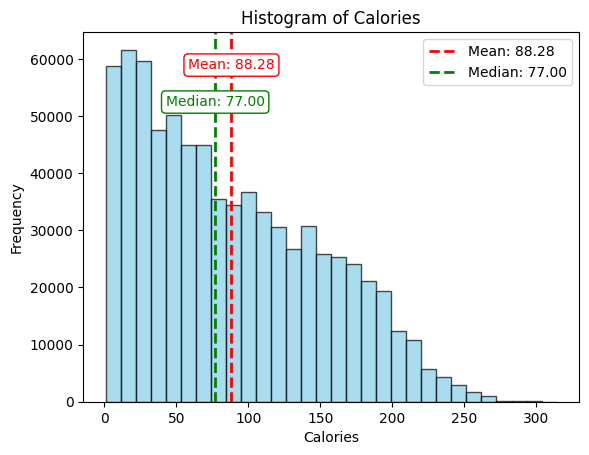

In [ ]:
if regression:
    # Histogram for continuous target
    plt.hist(train[target], bins=30, edgecolor='black', alpha=0.7, color='skyblue')

    # Calculate mean and median
    mean_value = np.mean(train[target])
    median_value = np.median(train[target])

    # Add vertical lines for mean and median
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

    # Add text annotations
    plt.text(mean_value, plt.ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))
    plt.text(median_value, plt.ylim()[1] * 0.8, f'Median: {median_value:.2f}', color='green', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

    # Labels and title
    plt.xlabel(target)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {target}")
    plt.legend()

else:
    # Pie chart for categorical target
    class_counts = train[target].value_counts()
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
    plt.title(f"Distribution of {target}")

plt.show()

In [ ]:
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

In [ ]:
categorical_cols

[]

#### Numeric

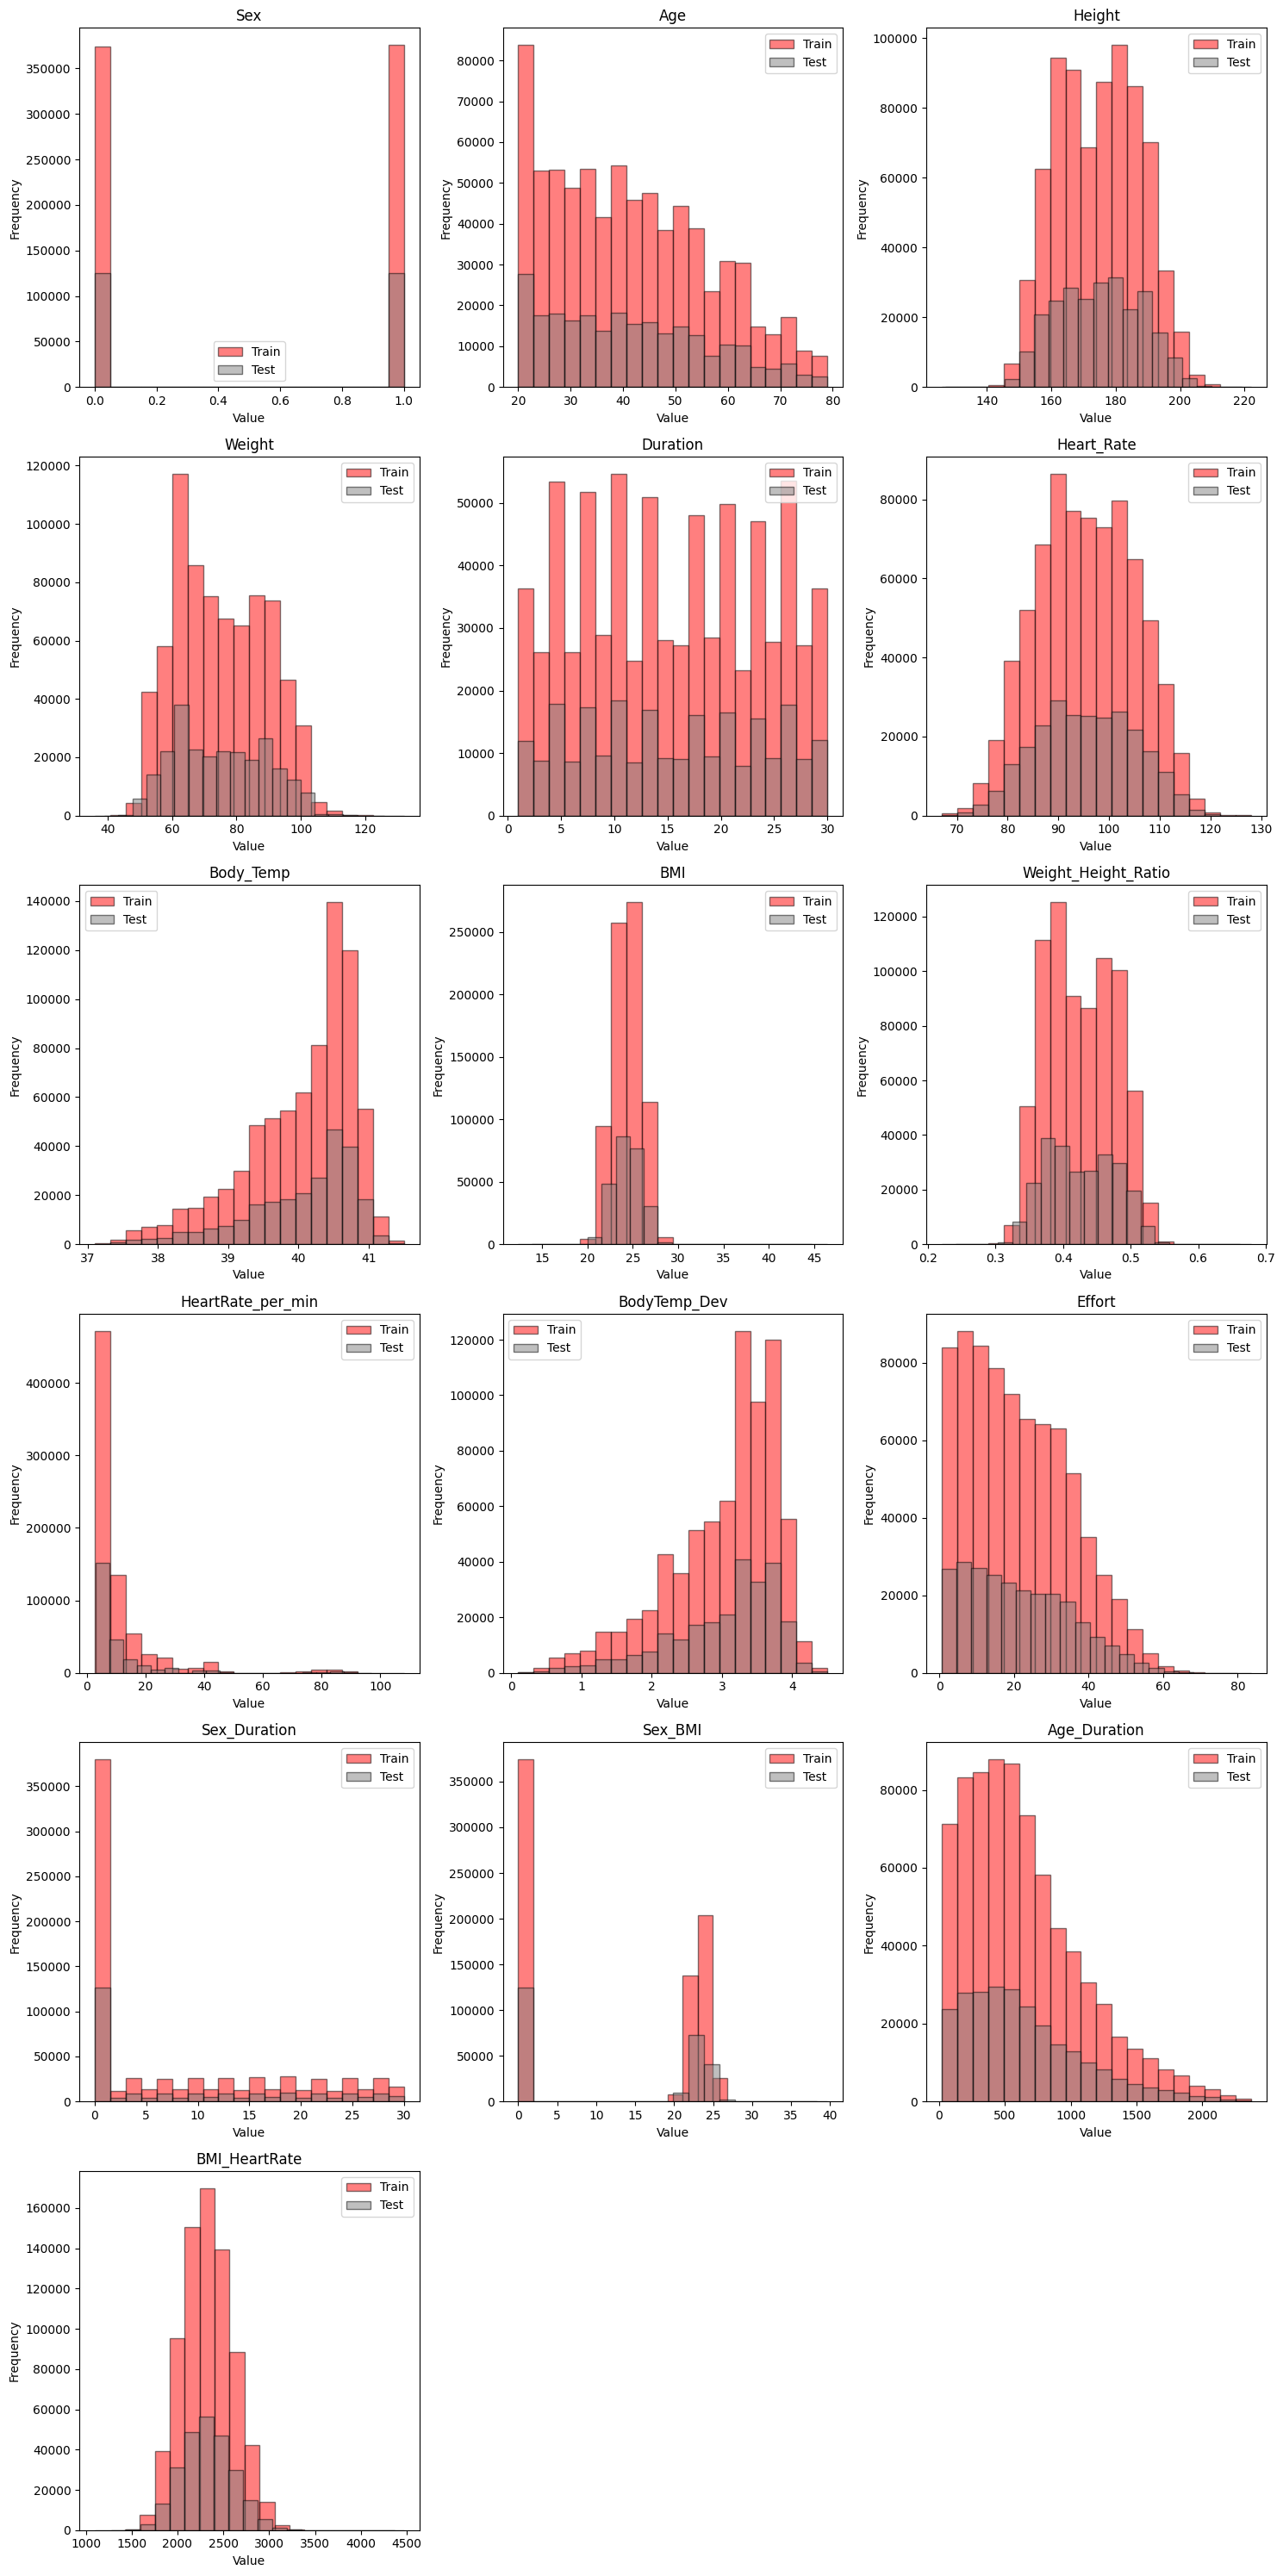

In [ ]:
# Calculate the number of rows needed for the subplots
num_rows = (len(numeric_cols) + 2) // 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each continuous column and plot the histograms
for i, col in enumerate(numeric_cols):
    # Determine the range of values to plot
    max_val = max(train[col].max(), test[col].max())
    min_val = min(train[col].min(), test[col].min())
    range_val = max_val - min_val

    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins = round(range_val / bin_size)

    # Plot the histograms
    axs[i].hist(train[col], bins=num_bins, color='red', alpha=0.5, label='Train', edgecolor='black')
    axs[i].hist(test[col], bins=num_bins, color='grey', alpha=0.5, label='Test', edgecolor='black')

    # Titles and labels
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
if regression:
    # Determine number of rows for subplots (3 columns per row)
  num_rows = (len(numeric_cols) + 2) // 3

  # Create subplots
  fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

  # Flatten the axs array for easy iteration
  axs = axs.flatten()

  # Loop through each numeric column and plot the scatter plot
  for i, col in enumerate(numeric_cols):
      axs[i].scatter(train[col], train[target], alpha=0.5, color='blue', edgecolors='black')
      axs[i].set_title(f"{col} vs {target}")
      axs[i].set_xlabel(col)
      axs[i].set_ylabel(target)

  # Remove any unused subplots
  for j in range(i + 1, len(axs)):
      fig.delaxes(axs[j])

  plt.tight_layout()
  plt.show()

KeyboardInterrupt: 

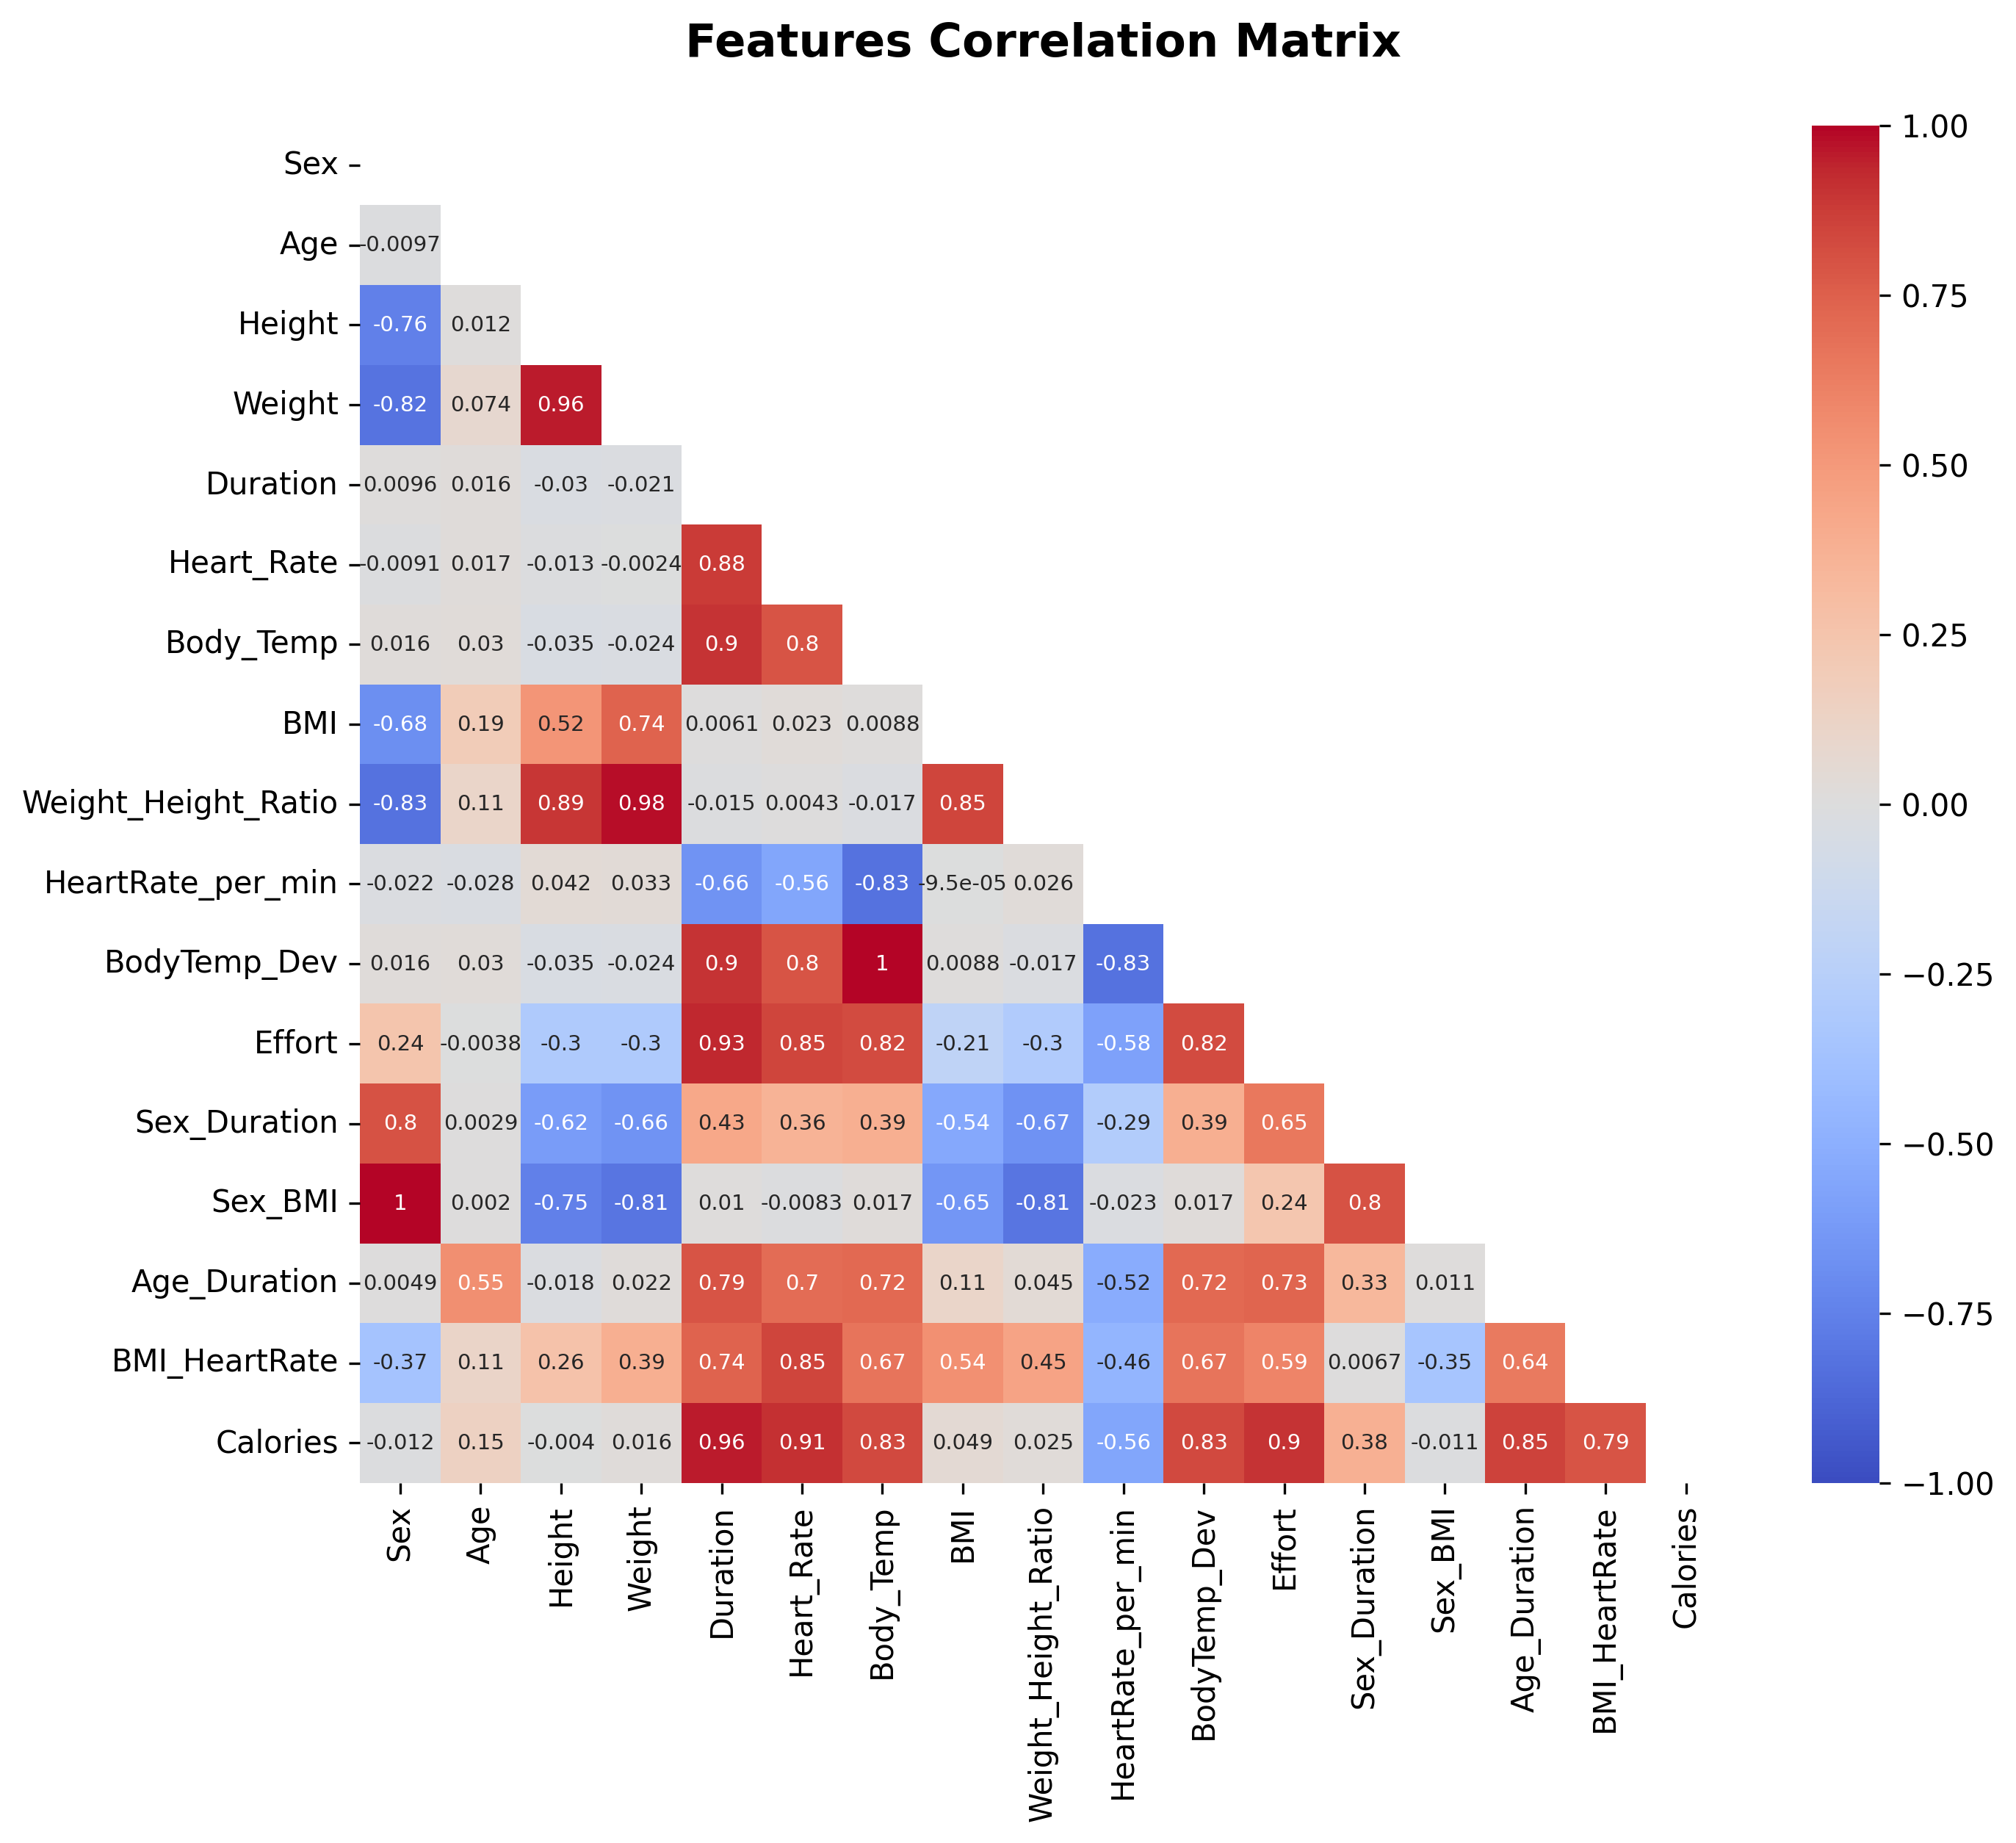

In [ ]:
if regression:
  corr = train[numeric_cols + [target]].corr()
  plt.figure(figsize = (10, 8), dpi = 300)
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(corr, mask = mask, cmap = 'coolwarm', annot = True, annot_kws = {'size' : 7}, vmin = -1, vmax = 1)
  plt.title('Features Correlation Matrix\n', fontsize = 15, weight = 'bold')
  plt.show()

#### Categorical

In [ ]:
categorical_cols

[]

In [ ]:
if regression:
  fig, axs = plt.subplots(len(categorical_cols), 1, figsize=(10, len(categorical_cols) * 4))

  for i, col in enumerate(categorical_cols):
      # Get the top 10 most frequent categories
      top_categories = train[col].value_counts().nlargest(10).index

      # Filter train data to only include top categories
      filtered_train = train[train[col].isin(top_categories)]

      # Create box plot
      axs[i].boxplot(
          [filtered_train[filtered_train[col] == category][target] for category in top_categories],
          labels=top_categories
      )

      axs[i].set_title(f"{col} vs {target}")
      axs[i].set_xlabel(col)
      axs[i].set_ylabel(target)
      axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

  plt.tight_layout()
  plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1000x0 with 0 Axes>

In [ ]:
if regression:
  from scipy.stats import kruskal

  kruskal_results = {}

  for col in categorical_cols:
      groups = [train[train[col] == category][target] for category in train[col].unique()]
      if len(groups) > 1:
          stat, p = kruskal(*groups)
          kruskal_results[col] = {"Kruskal-Wallis Statistic": stat, "p-value": p}

  # Convert to DataFrame
  kruskal_df = pd.DataFrame.from_dict(kruskal_results, orient="index")
  display(kruskal_df.sort_values(by="Kruskal-Wallis Statistic", ascending=False))

# Higher statistic → Stronger categorical effect

# Lower p-value → More significant relationship

### Unique

In [ ]:
# Drop the target column
X = train.drop(columns=[target, 'Age_bin'])

# Compute correlation matrix
corr_matrix = X.corr().abs()

# Set the diagonal to 0 (ignore self-correlation)
np.fill_diagonal(corr_matrix.values, 0)

# Find highly correlated pairs (e.g., correlation > 0.85)
threshold = 0.85
high_corr = np.where(corr_matrix > threshold)

# Extract column pairs
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iat[i, j])
                   for i, j in zip(*high_corr) if i < j]  # avoid duplicates (i,j) and (j,i)

In [ ]:
high_corr_pairs

[('Sex', 'Sex_BMI', np.float64(0.997715164447692)),
 ('Height', 'Weight', np.float64(0.9579665118458507)),
 ('Height', 'Weight_Height_Ratio', np.float64(0.8949663127853047)),
 ('Weight', 'Weight_Height_Ratio', np.float64(0.9838672308847115)),
 ('Duration', 'Heart_Rate', np.float64(0.8753270681992044)),
 ('Duration', 'Body_Temp', np.float64(0.903065980941379)),
 ('Duration', 'BodyTemp_Dev', np.float64(0.9030659809413817)),
 ('Duration', 'Effort', np.float64(0.934823252048426)),
 ('Body_Temp', 'BodyTemp_Dev', np.float64(1.0000000000000036))]

## HBGB

In [ ]:
# target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]
# numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
# categorical_cols = test.select_dtypes([object]).columns.tolist() + [	'Duration_bin']

# X = train.drop(columns=[target, 'Sex' ])  # Features
# y = train[target]  # Target

# X[categorical_cols] = X[categorical_cols].astype('category')

# n_splits = 5
# # skf = StratifiedKFold(n_splits=n_splits, shuffle=False)#, random_state=30)
# # n_splits = train.shape[0] // 365  # Ensure total_rows is defined
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=30)

# numeric_cols = X.select_dtypes([int, float,bool]).columns.tolist()

In [ ]:
# # Define Preprocessing
# preprocessor = ColumnTransformer(transformers=[
#     ('num', Pipeline([
#         ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
#         ('scaler', StandardScaler())  # Scale numerical features
#     ]), numeric_cols),

#     ('cat', Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
#         # ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encode categories
#         ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
#     ]), categorical_cols)
# ])

# # Define HistGradientBoosting parameters
# hgb_params = {'learning_rate': 0.03703245651885418, 'max_iter': 598, 'max_leaf_nodes': 91, 'max_depth': 8,
#               'min_samples_leaf': 29, 'l2_regularization': 5.422754113972644, 'max_features': 0.5684081355960205, 'max_bins': 187,
#               'validation_fraction': 0.1794649110845616, 'n_iter_no_change': 17, 'tol': 1.5708608100840894e-06,'random_state': 30}


# # Define full pipeline
# hbgb_pipeline = Pipeline([
#     ('preprocessor', preprocessor),  # Preprocess data
#     ('model', HistGradientBoostingRegressor( **hgb_params))  # Train model
# ])

# # Store out-of-fold (OOF) predictions
# hgb_oof_preds = np.zeros(len(train))
# hgb_fold_scores = []
# hgb_pred = np.zeros(len(test))

# # K-Fold Cross-Validation for Regression
# for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
#     print(f"Training fold {fold+1}...")

#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


#     y_train = np.log1p(y_train)
#     y_val = np.log1p(y_val)

#     # Fit pipeline
#     hbgb_pipeline.fit(X_train, y_train)

#     # Predict continuous values
#     fold_pred = hbgb_pipeline.predict(X_val)
#     hgb_oof_preds[val_idx] = fold_pred

#     # Compute RMSE for the fold
#     fold_rmse = root_mean_squared_log_error(np.expm1( y_val), np.expm1( fold_pred))
#     hgb_fold_scores.append(fold_rmse)
#     print(f"Fold {fold+1} RMSE: {fold_rmse:.4f}")

#     # Predict Test
#     hgb_pred += hbgb_pipeline.predict(test)

# # Compute overall RMSE
# overall_rmse = root_mean_squared_log_error(y, np.expm1( hgb_oof_preds))
# print("\nFold RMSE Scores:", hgb_fold_scores)
# print(f"Overall RMSE Score: {overall_rmse:.4f}")

Training fold 1...
Fold 1 RMSE: 0.0605
Training fold 2...
Fold 2 RMSE: 0.0603
Training fold 3...
Fold 3 RMSE: 0.0607
Training fold 4...
Fold 4 RMSE: 0.0601
Training fold 5...
Fold 5 RMSE: 0.0614

Fold RMSE Scores: [0.06047989924278171, 0.060254401286622544, 0.060727191829446435, 0.06013743592555723, 0.06136942283625299]
Overall RMSE Score: 0.0606


In [ ]:
preprocessor = hbgb_pipeline.named_steps['preprocessor']  # adjust if your preprocessor step has a different name

# Get feature names after transformation
feature_names = []

for name, transformer, columns in preprocessor.transformers_:
    if transformer == 'drop':
        continue
    elif transformer == 'passthrough':
        feature_names.extend(columns)
    else:
        # Some transformers have get_feature_names_out()
        try:
            transformed_features = transformer.get_feature_names_out(columns)
        except AttributeError:
            transformed_features = columns  # fallback if the transformer doesn't support get_feature_names_out
        feature_names.extend(transformed_features)

print("Features used in hbgb_pipeline:")
print(feature_names)

Features used in hbgb_pipeline:
['BMI', 'Weight_Height_Ratio', 'HeartRate_per_min', 'Effort', 'Age', 'Body_Temp', 'Duration', 'Heart_Rate', 'Height', 'Sex', 'Weight', 'Age^2', 'Age Body_Temp', 'Age Duration', 'Age Heart_Rate', 'Age Height', 'Age Sex', 'Age Weight', 'Body_Temp^2', 'Body_Temp Duration', 'Body_Temp Heart_Rate', 'Body_Temp Height', 'Body_Temp Sex', 'Body_Temp Weight', 'Duration^2', 'Duration Heart_Rate', 'Duration Height', 'Duration Sex', 'Duration Weight', 'Heart_Rate^2', 'Heart_Rate Height', 'Heart_Rate Sex', 'Heart_Rate Weight', 'Height^2', 'Height Sex', 'Height Weight', 'Sex^2', 'Sex Weight', 'Weight^2', 'Duration_bin_0-10', 'Duration_bin_10-20', 'Duration_bin_20-30']


In [ ]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist() + [	'Duration_bin']

X = train.drop(columns=[target])  # Features
y = train[target]  # Target

X[categorical_cols] = X[categorical_cols].astype('category')

n_splits = 25
# skf = StratifiedKFold(n_splits=n_splits, shuffle=False)#, random_state=30)
# n_splits = train.shape[0] // 365  # Ensure total_rows is defined
kf = KFold(n_splits=n_splits, shuffle=True, random_state=30)

numeric_cols = X.select_dtypes([int, float,bool]).columns.tolist()

from sklearn.preprocessing import PolynomialFeatures
poly_cols = ['Age', 'Body_Temp', 'Duration', 'Heart_Rate', 'Height',  'Weight',  'Sex' ]
rest_num_cols = [col for col in numeric_cols if col not in poly_cols]

# Define Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
        ('scaler', StandardScaler())  # Scale numerical features
    ]), rest_num_cols),

     ('poly', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('scaler', StandardScaler())
    ]), poly_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
        # ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encode categories
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
])

# Define HistGradientBoosting parameters
hgb_params = {'learning_rate': 0.03703245651885418, 'max_iter': 598, 'max_leaf_nodes': 91, 'max_depth': 8,
              'min_samples_leaf': 29, 'l2_regularization': 5.422754113972644, 'max_features': 0.5684081355960205, 'max_bins': 187,
              'validation_fraction': 0.1794649110845616, 'n_iter_no_change': 17, 'tol': 1.5708608100840894e-06,'random_state': 30}


# Define full pipeline
hbgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocess data
    ('model', HistGradientBoostingRegressor( **hgb_params))  # Train model
])

# Store out-of-fold (OOF) predictions
hgb_oof_preds = np.zeros(len(train))
hgb_fold_scores = []
hgb_pred = np.zeros(len(test))

# K-Fold Cross-Validation for Regression
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold+1}...")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)

    # Fit pipeline
    hbgb_pipeline.fit(X_train, y_train)

    # Predict continuous values
    fold_pred = hbgb_pipeline.predict(X_val)
    hgb_oof_preds[val_idx] = fold_pred

    # Compute RMSE for the fold
    fold_rmse = root_mean_squared_log_error(np.expm1( y_val), np.expm1( fold_pred))
    hgb_fold_scores.append(fold_rmse)
    print(f"Fold {fold+1} RMSE: {fold_rmse:.4f}")

    # Predict Test
    hgb_pred += hbgb_pipeline.predict(test)

# Compute overall RMSE
overall_rmse = root_mean_squared_log_error(y, np.expm1( hgb_oof_preds))
print("\nFold RMSE Scores:", hgb_fold_scores)
print(f"Overall RMSE Score: {overall_rmse:.4f}")

Training fold 1...
Fold 1 RMSE: 0.0603
Training fold 2...
Fold 2 RMSE: 0.0601
Training fold 3...
Fold 3 RMSE: 0.0609
Training fold 4...
Fold 4 RMSE: 0.0610
Training fold 5...
Fold 5 RMSE: 0.0588
Training fold 6...
Fold 6 RMSE: 0.0600
Training fold 7...
Fold 7 RMSE: 0.0628
Training fold 8...
Fold 8 RMSE: 0.0584
Training fold 9...
Fold 9 RMSE: 0.0584
Training fold 10...
Fold 10 RMSE: 0.0592
Training fold 11...
Fold 11 RMSE: 0.0620
Training fold 12...
Fold 12 RMSE: 0.0576
Training fold 13...
Fold 13 RMSE: 0.0630
Training fold 14...
Fold 14 RMSE: 0.0611
Training fold 15...
Fold 15 RMSE: 0.0587
Training fold 16...
Fold 16 RMSE: 0.0611
Training fold 17...
Fold 17 RMSE: 0.0600
Training fold 18...
Fold 18 RMSE: 0.0608
Training fold 19...
Fold 19 RMSE: 0.0591
Training fold 20...
Fold 20 RMSE: 0.0577
Training fold 21...
Fold 21 RMSE: 0.0612
Training fold 22...
Fold 22 RMSE: 0.0625
Training fold 23...
Fold 23 RMSE: 0.0601
Training fold 24...
Fold 24 RMSE: 0.0631
Training fold 25...
Fold 25 RMSE: 

In [ ]:
# Fold RMSE Scores: [0.06390470078625497, 0.06330004477663084, 0.06371783254867604, 0.06288746619856328, 0.06459881162044895]
# Fold RMSE Scores: [0.06383008518462978, 0.06332333488151866, 0.06367171631012593, 0.06282708592239268, 0.06452176289124703]
# Overall RMSE Score: 0.0636
# Fold RMSE Scores: [0.06379443615905082, 0.06340702741146284, 0.06376769861579784, 0.06271883154078596, 0.06464729055533357]
# Overall RMSE Score: 0.0637
# Overall RMSE Score: 0.0606
# Fold RMSE Scores: [0.06057196438809561, 0.06020843141684534, 0.06082592903184003, 0.060059532998787246, 0.06136680822399586]

# Fold RMSE Scores: [0.06043132073586111, 0.06033449426004081, 0.06093852428428027, 0.0600436611036193, 0.06129216137351814]
# Overall RMSE Score: 0.0606

# Fold RMSE Scores: [0.06111772559435818, 0.05981605107856198, 0.06071953892317494,
# 0.05938170788453337, 0.06097441908388417, 0.06026857541995694, 0.060631280793184215,
#  0.059099762260442355, 0.06200042693855598, 0.06083225295905064]
# Overall RMSE Score: 0.0605

# Fold RMSE Scores: [0.060332154056026537, 0.06035103243253176, 0.0609264972466009,
#                    0.06110311249875001, 0.058839605443375714, 0.06016578431093265,
#                    0.06295496713155621, 0.05871750921324087, 0.05867648025769986, 0.059375408408493466,
#                    0.061990094735704646, 0.05769626546249956, 0.06291433694299112, 0.06135942994569952,
#                    0.05894905241117187, 0.061154248031300144, 0.06006328352481555, 0.06059546074274355,
#                    0.059404203564895126, 0.05738502854564001, 0.061291848888914896, 0.06269200347670702,
#                    0.06008021219895351, 0.06323337461031174, 0.058560779017525315]
# Overall RMSE Score: 0.0604

In [ ]:
# hgb_model = hbgb_pipeline.fit(X, y)
# hgb_model.fit(X, y)

# # Make predictions
# hgb_pred = hgb_model.predict(test)  # use trained model from training
hgb_pred_fold = hgb_pred/n_splits
mn = train.Calories.min()
mx = train.Calories.max()

# Save submission
sub[target] = np.clip( np.expm1( hgb_pred_fold),mn,mx )

# surrounded_with_target = surrounded_with_target.set_index('index')
# sub['Calories'] = sub.apply(
#     lambda row: surrounded_with_target.loc[row['id'], 'Calories_y'] if row['id'] in surrounded_with_target.index else row['Calories'],
#     axis=1
# )

sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index=False)

<Axes: >

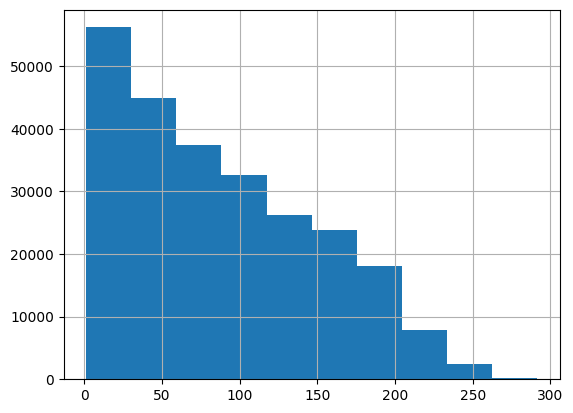

In [ ]:
sub[target].hist()

In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e5 -f /content/drive/MyDrive/Output/sub.csv -m "hbg optuna with nplog duplicates2 poly3 features 10 fold"

100% 6.06M/6.06M [00:00<00:00, 8.57MB/s]
Successfully submitted to Predict Calorie Expenditure

### Hyp Tune

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=30)
def objective(trial):
    params = {
        'loss': 'squared_error',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 10.0),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'max_bins': trial.suggest_int('max_bins', 50, 255),
        'early_stopping': 'auto',
        'scoring': 'loss',
        'validation_fraction': trial.suggest_float('validation_fraction', 0.05, 0.3),
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 20),
        'tol': trial.suggest_float('tol', 1e-8, 1e-5, log=True),
        'random_state': 30
    }

    # Define updated preprocessor with TargetEncoder
    from sklearn.preprocessing import PolynomialFeatures
    poly_cols = ['Age', 'Body_Temp', 'Duration', 'Heart_Rate', 'Height', 'Sex', 'Weight']
    rest_num_cols = [col for col in numeric_cols if col not in poly_cols]

    # Define Preprocessing
    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
            ('scaler', StandardScaler())  # Scale numerical features
        ]), rest_num_cols),

        ('poly', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('poly', PolynomialFeatures(degree=4, include_bias=False)),
            ('scaler', StandardScaler())
        ]), poly_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
            # ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encode categories
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

    # Full pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', HistGradientBoostingRegressor(**params))
    ])

    # Evaluate with cross-validation
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_root_mean_squared_log_error', n_jobs=-1)
    return np.mean(scores)

# Run Optuna study
study = optuna.create_study(direction="maximize")

# initial_params = {'learning_rate': 0.03703245651885418, 'max_iter': 598, 'max_leaf_nodes': 91, 'max_depth': 8,
#               'min_samples_leaf': 29, 'l2_regularization': 5.422754113972644, 'max_features': 0.5684081355960205, 'max_bins': 187,
#               'validation_fraction': 0.1794649110845616, 'n_iter_no_change': 17, 'tol': 1.5708608100840894e-06,'random_state': 30}

# # Manually evaluate the objective with the starting parameters
# trial = study.ask(fixed_params=initial_params)
# score = objective(trial)
# study.tell(trial, score)


study.optimize(objective, n_trials=50, n_jobs=-1)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2025-05-24 13:02:46,652] A new study created in memory with name: no-name-a2053586-2e98-4434-b653-219bc1b89d3b
[I 2025-05-24 13:51:13,365] Trial 0 finished with value: -0.10551797485627439 and parameters: {'learning_rate': 0.022449909814717187, 'max_iter': 171, 'max_leaf_nodes': 83, 'max_depth': 13, 'min_samples_leaf': 14, 'l2_regularization': 1.366363081449944, 'max_features': 0.5857555231253302, 'max_bins': 88, 'validation_fraction': 0.21289342535233885, 'n_iter_no_change': 20, 'tol': 1.7083934051270045e-06}. Best is trial 0 with value: -0.10551797485627439.
[I 2025-05-24 13:55:35,565] Trial 1 finished with value: -0.07694830587778577 and parameters: {'learning_rate': 0.035403888370291084, 'max_iter': 901, 'max_leaf_nodes': 20, 'max_depth': 2, 'min_samples_leaf': 49, 'l2_regularization': 5.630600068318564, 'max_features': 0.23516945490458524, 'max_bins': 74, 'validation_fraction': 0.2566531742717131, 'n_iter_no_change': 10, 'tol': 7.1156446671152e-07}. Best is trial 1 with value: 

In [ ]:
# import pickle

# # Save the sampler with pickle to be loaded later.
# with open("sampler.pkl", "wb") as fout:
#     pickle.dump(study.sampler, fout)

# restored_sampler = pickle.load(open("sampler.pkl", "rb"))
# study = optuna.create_study(
#     study_name=study_name, storage=storage_name, load_if_exists=True, sampler=restored_sampler
# )
# study.optimize(objective, n_trials=3)

## XGB

In [ ]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]
X = train.drop(columns=[target, 'Sex', 'Age_bin' ])   # Features
y = train[target]  # Target

X[categorical_cols] = X[categorical_cols].astype('category')

n_splits = 10
# skf = StratifiedKFold(n_splits=n_splits, shuffle=False)#, random_state=30)
# n_splits = train.shape[0] // 365  # Ensure total_rows is defined
kf = KFold(n_splits=n_splits, shuffle=True, random_state=30)

In [ ]:
# Store out-of-fold (OOF) predictions and fold scores
xgb_oof_preds = np.zeros(len(train))
xgb_fold_scores = []
xgb_pred = np.zeros(len(test))

# XGBoost parameters
xgb_params ={'learning_rate': 0.018167360046802764, 'max_depth': 10, 'subsample': 0.8583998001088201,
             'colsample_bytree': 0.6505883199641187,
             'n_estimators': 1000, 'reg_alpha': 0.01923993395499752, 'reg_lambda': 0.032233880379441984,
    "random_state": 30
}

features_used = list(X.columns)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold+1}...")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)

    xgb_model = xgb.XGBRegressor(**xgb_params, enable_categorical=True)
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    fold_pred = xgb_model.predict(X_val)
    xgb_oof_preds[val_idx] = fold_pred

    xgb_pred += xgb_model.predict(test[list(X.columns)])

    # Compute AUC for the fold
    fold_auc = root_mean_squared_log_error(np.expm1(y_val), np.expm1(fold_pred))
    xgb_fold_scores.append(fold_auc)
    print(f"Fold {fold+1} SCORE: {fold_auc:.4f}")

# Compute overall AUC score
overall_auc = root_mean_squared_log_error(y, np.expm1(xgb_oof_preds))
print("\nFold Scores:", xgb_fold_scores)
print(f"Overall Score: {overall_auc:.4f}")

Training fold 1...
Fold 1 SCORE: 0.0607
Training fold 2...
Fold 2 SCORE: 0.0595
Training fold 3...
Fold 3 SCORE: 0.0598
Training fold 4...
Fold 4 SCORE: 0.0590
Training fold 5...
Fold 5 SCORE: 0.0608
Training fold 6...
Fold 6 SCORE: 0.0609
Training fold 7...
Fold 7 SCORE: 0.0606
Training fold 8...
Fold 8 SCORE: 0.0590
Training fold 9...
Fold 9 SCORE: 0.0616
Training fold 10...
Fold 10 SCORE: 0.0606

Fold Scores: [0.06065006600775732, 0.05945155729196299, 0.05980996089345583, 0.05904105233053472, 0.060823719814397416, 0.060909917770983805, 0.06056027742694623, 0.05898175120723879, 0.0616419266274309, 0.06064109609336236]
Overall Score: 0.0603


In [ ]:
# target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]
# X = train.drop(columns=[target ])   # Features
# y = train[target]  # Target

# X[categorical_cols] = X[categorical_cols].astype('category')

# n_splits = 5
# # skf = StratifiedKFold(n_splits=n_splits, shuffle=False)#, random_state=30)
# # n_splits = train.shape[0] // 365  # Ensure total_rows is defined
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=30)
# poly = PolynomialFeatures(degree=2, include_bias=False)
# poly_cols = ['Age', 'Body_Temp', 'Duration', 'Heart_Rate', 'Height', 'Sex', 'Weight']
# rest_num_cols = [col for col in numeric_cols if col not in poly_cols]

# # Store out-of-fold (OOF) predictions and fold scores
# xgb_oof_preds = np.zeros(len(train))
# xgb_fold_scores = []
# xgb_pred = np.zeros(len(test))

# # XGBoost parameters
# xgb_params ={'learning_rate': 0.018167360046802764, 'max_depth': 10, 'subsample': 0.8583998001088201,
#              'colsample_bytree': 0.6505883199641187,
#              'n_estimators': 1000, 'reg_alpha': 0.01923993395499752, 'reg_lambda': 0.032233880379441984,
#     "random_state": 30
# }

# features_used = list(X.columns)

# for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
#     print(f"Training fold {fold+1}...")

#     # Get the data split
#     X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     # Generate polynomial features for poly_cols
#     X_train_poly = poly.fit_transform(X_train[poly_cols])
#     X_val_poly = poly.transform(X_val[poly_cols])
#     test_poly = poly.transform(test[poly_cols])

#     # Get column names for polynomial features
#     poly_feature_names = poly.get_feature_names_out(poly_cols)

#     # Convert to DataFrames for easy merging
#     X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=X_train.index)
#     X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly_feature_names, index=X_val.index)
#     test_poly_df = pd.DataFrame(test_poly, columns=poly_feature_names, index=test.index)

#     # Drop original poly_cols (optional, if you only want the poly versions)
#     # X_train.drop(columns=poly_cols, inplace=True)
#     # X_val.drop(columns=poly_cols, inplace=True)
#     # test.drop(columns=poly_cols, inplace=True)

#     # Concatenate polynomial features
#     X_train = pd.concat([X_train[rest_num_cols ], X_train_poly_df], axis=1)
#     X_val = pd.concat([X_val[rest_num_cols ], X_val_poly_df], axis=1)
#     test_augmented = pd.concat([test[rest_num_cols].copy(), test_poly_df], axis=1)

#     # Log-transform targets
#     y_train = np.log1p(y_train)
#     y_val = np.log1p(y_val)

#     # Train XGBoost
#     xgb_model = xgb.XGBRegressor(**xgb_params, enable_categorical=True)
#     xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

#     # Predict
#     fold_pred = xgb_model.predict(X_val)
#     xgb_oof_preds[val_idx] = fold_pred
#     xgb_pred += xgb_model.predict(test_augmented) / kf.get_n_splits()

#     # Score
#     fold_score = root_mean_squared_log_error(np.expm1(y_val), np.expm1(fold_pred))
#     xgb_fold_scores.append(fold_score)
#     print(f"Fold {fold+1} SCORE: {fold_score:.4f}")

# # Final score
# overall_auc = root_mean_squared_log_error(y, np.expm1(xgb_oof_preds))
# print("\nFold Scores:", xgb_fold_scores)
# print(f"Overall Score: {overall_auc:.4f}")

Training fold 1...
Fold 1 SCORE: 0.0602
Training fold 2...
Fold 2 SCORE: 0.0596
Training fold 3...
Fold 3 SCORE: 0.0609
Training fold 4...
Fold 4 SCORE: 0.0600
Training fold 5...
Fold 5 SCORE: 0.0615

Fold Scores: [0.06017053312180468, 0.0596277376599127, 0.060891090000008606, 0.059972266281356955, 0.06148532981912154]
Overall Score: 0.0604


In [ ]:
# Fold Scores: [0.060197343415173896, 0.05976889902985423, 0.06080764057222572, 0.059993806745791606, 0.061195612473906674]
# Overall Score: 0.0604

# Fold Scores: [0.06012934901211408, 0.05968470288020419, 0.06073607681300999, 0.05998491514441549, 0.06118680535650497]
# Overall Score: 0.0603

# # Fit model on full training data
# xgb_model = xgb.XGBRegressor(**xgb_params, enable_categorical=True)
# xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6505883199641187, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.018167360046802764, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=30, ...)

In [ ]:
# test[categorical_cols] = test[categorical_cols].astype('category')
# xgb_pred = xgb_model.predict(test[list(X.columns)])

xgb_pred_fold = xgb_pred/n_splits
mn = train.Calories.min()
mx = train.Calories.max()

# Save submission
sub[target] = np.clip( np.expm1( xgb_pred_fold),mn,mx )
# sub[target] = xgb_pred
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index = False)

<Axes: >

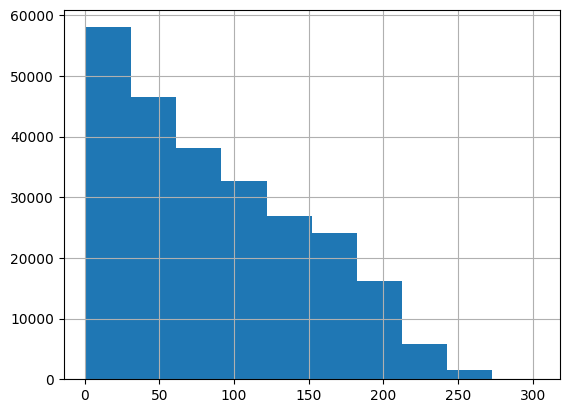

In [ ]:
sub[target].hist()

In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e5 -f /content/drive/MyDrive/Output/sub.csv -m "xgb optuna with nplog"

100% 6.06M/6.06M [00:00<00:00, 22.3MB/s]
Successfully submitted to Predict Calorie Expenditure

### Hyp Tune

In [ ]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmsle",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 10.0),
        "random_state": 30,
        "use_label_encoder": False
    }

    n_splits = 5  # Ensure total_rows is defined
    kf = KFold(n_splits=n_splits, shuffle=True)  # Adjust shuffle if needed
    oof_preds = np.zeros(len(y))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBRegressor(**params, enable_categorical=True)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        fold_pred = model.predict(X_val)
        oof_preds[val_idx] = fold_pred
    oof_preds = np.maximum(oof_preds, 1)
    return root_mean_squared_log_error(y, oof_preds)

# Run Optuna hyperparameter optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Get best hyperparameters
best_params = study.best_params

[I 2025-05-09 15:32:04,700] A new study created in memory with name: no-name-3cbbbe63-20ac-4834-95b7-25c5150011ea
<ipython-input-20-98d8d0b37a93>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-20-98d8d0b37a93>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10.0),
<ipython-input-20-98d8d0b37a93>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.sug

## NN

In [ ]:
def rmsle(y_true, y_pred):
    # Add small constant to avoid log(0)
    return K.sqrt(K.mean(K.square(K.log1p(y_pred) - K.log1p(y_true))))

In [ ]:
n_splits = 10

# Prepare features and target
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

X = train.drop(columns=[target, 'Sex', 'Age_bin'])
y = train[target]

# Categorical & numerical columns
X[categorical_cols] = X[categorical_cols].astype('category')
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Model builder for regression
def build_model(units, input_dim):
    inp = Input(shape=(input_dim,))
    x = inp

    for i in range(0, len(units), 2):
        u1, u2 = units[i], units[i+1] if i+1 < len(units) else units[i]

        y = Dense(u1, activation=None)(x)
        y = BatchNormalization()(y)
        y = Activation('swish')(y)

        y = Dense(u2, activation=None)(y)
        y = BatchNormalization()(y)

        if x.shape[-1] != u2:
            shortcut = Dense(u2, activation=None)(x)
            shortcut = BatchNormalization()(shortcut)
        else:
            shortcut = x

        x = Add()([shortcut, y])
        x = Activation('swish')(x)

    out = Dense(1, activation='linear')(x)
    return Model(inputs=inp, outputs=out)

ARCH   = [128, 64, 64, 32]

# K-Fold CV
kf = KFold(n_splits=n_splits, shuffle=True, random_state=30)

nn_pred = np.zeros(len(test))
nn_oof_preds = np.zeros(len(train))
nn_fold_scores = []
fold = 1

for train_index, val_index in kf.split(X):
    print(f"\n📁 Fold {fold}")

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    y_train = np.log1p( y_train )
    y_val = np.log1p(y_val)

    # Transform features
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(test)

    # Build model
    model = build_model(units = ARCH, input_dim=X_train_prep.shape[1])
    model.compile(
            optimizer=tf.keras.optimizers.Adam(0.001),
            loss='mse',
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    # Early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_callback = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )

    # Train model
    model.fit(
        X_train_prep, y_train,
        validation_data=(X_val_prep, y_val),
        epochs=100,
        batch_size=256,
        callbacks=[early_stop,lr_callback],
        verbose=2
    )

    # Evaluate
    fold_pred = model.predict(X_val_prep).flatten()
    nn_oof_preds[val_index] = fold_pred
    rmse = root_mean_squared_log_error(np.expm1(y_val), np.expm1(fold_pred))
    nn_fold_scores.append(rmse)
    print(f"✅ Fold {fold} RMSE: {rmse:.4f}")

    X_test_prep = preprocessor.transform(test)
    nn_pred += model.predict(X_test_prep).flatten()


    fold += 1


📁 Fold 1
Epoch 1/100
2610/2610 - 24s - 9ms/step - loss: 0.1153 - root_mean_squared_error: 0.3396 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838 - learning_rate: 1.0000e-03
Epoch 2/100
2610/2610 - 22s - 8ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0773 - learning_rate: 1.0000e-03
Epoch 3/100
2610/2610 - 17s - 7ms/step - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1266 - learning_rate: 1.0000e-03
Epoch 4/100
2610/2610 - 20s - 8ms/step - loss: 0.0055 - root_mean_squared_error: 0.0738 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0683 - learning_rate: 1.0000e-03
Epoch 5/100
2610/2610 - 20s - 8ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0648 - learning_rate: 1.0000e-03
Epoch 6/100
2610/2610 - 20s - 8ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0044 - val_root_mean_sq

In [ ]:
overall_auc = root_mean_squared_log_error(y, np.expm1(nn_oof_preds))
print("\nFold Scores:", nn_fold_scores)
print(f"Overall Score: {overall_auc:.4f}")

In [ ]:
# base  0.0638

# Fold Scores: [0.05970793667020438, 0.05940357032395139, 0.059918705393921974, 0.059306507628953814, 0.060797835199196446]
# Overall Score: 0.0598

In [ ]:
nn_pred_fold = nn_pred/n_splits
mn = train.Calories.min()
mx = train.Calories.max()

# Save submission
sub[target] = np.clip( np.expm1( nn_pred_fold),mn,mx )
# sub[target] = xgb_pred
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index = False)

In [ ]:
# Submit
# !kaggle competitions submit -c playground-series-s5e5 -f /content/drive/MyDrive/Output/sub.csv -m "tf preds"

100% 6.06M/6.06M [00:00<00:00, 21.9MB/s]
Successfully submitted to Predict Calorie Expenditure

In [ ]:
# X_prep = preprocessor.fit_transform(X)

# # Step 2: Build final model
# final_model = create_model(input_dim=X_prep.shape[1])

# # Step 3: EarlyStopping
# early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# # Step 4: Train final model
# final_model.fit(
#     X_prep, y,
#     epochs=100,
#     batch_size=32,
#     callbacks=[early_stop,lr_callback],
#     verbose=2
# )

Epoch 1/100
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 374.2937 - mae: 10.4773
Epoch 2/100
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 82.7902 - mae: 6.2241
Epoch 3/100
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 74.0749 - mae: 6.0160
Epoch 4/100
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 71.0259 - mae: 5.9215
Epoch 5/100
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 69.0210 - mae: 5.8638
Epoch 6/100
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - loss: 67.8261 - mae: 5.8225
Epoch 7/100
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - loss: 68.2063 - mae: 5.8074
Epoch 8/100
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 69.0961 - mae: 5.8237
Epoch 9/100
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 66.2442 - mae: 5.7497
Epoch 10/100
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - loss: 65.7197 - mae: 5.7139
Epoch 11/100
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 65.9124 - mae: 5.7147
Epoch 12/100
23438/23438 ━━━

In [ ]:
# test[categorical_cols] = test[categorical_cols].astype('category')
# X_test_prep = preprocessor.transform(test)

# # Predict
# predictions = final_model.predict(X_test_prep).flatten()

## GPU Hill Climb

In [ ]:
files = []
x_train = []
x_test = []
# PATH = "/kaggle/input/may2025-playground-oofs-testpreds/"

print("Loading files...")
for c in [hgb_oof_preds,xgb_oof_preds,nn_oof_preds]:
    print(f"=> {c} ",end="")
    oof = c
    # IF NOT LOG1P THEN APPLY LOG1P
    if oof.mean()>10: oof = np.log1p(oof)
    x_train.append(oof)
    files.append(f"oof_{c}")
    # df = pd.read_csv(f"{PATH}submission_{c}.csv")

for c in [hgb_pred_fold, xgb_pred_fold, nn_pred_fold]:
  oof = c
  # IF NOT LOG1P THEN APPLY LOG1P
  if oof.mean()>10: oof = np.log1p(oof)
  x_test.append(oof)
  print()

In [ ]:
x_train = np.stack(x_train).T
print("Our combined OOF have shape:",x_train.shape)

x_test = np.stack(x_test).T
print("Our combined PRED have shape:",x_test.shape)

In [ ]:
true = np.log1p( train.Calories.values )
def compute_metric_rmse(p):
    m = np.sqrt(np.mean( (p-true)**2.0 ) )
    return m

# COMPUTE METRIC FOR EACH OOF
best_score = 40
best_index = -1

for k,name in enumerate( files ):
    s = compute_metric_rmse(x_train[:,k])
    if s < best_score:
        best_score = s
        best_index = k
    print(f'RMSE {s:0.5f} {name}')
print()
print(f'Best single model is {files[best_index]} with RMSE = {best_score:0.5f}')

In [ ]:
import cupy as cp, gc

def multiple_rmse_scores(actual, predicted):
    """
    Computes multiple approximate AUC scores using GPU.

    This function calculates K approximate AUC scores simultaneously for a binary classification
    problem. The implementation does not handle ties in predictions correctly, making it an
    approximate AUC computation. The function is based on the algorithm outlined in:
    https://github.com/benhamner/Metrics/blob/master/R/R/metrics.r

    Parameters:
    ----------
    actual : cupy.ndarray
        A 1D GPU array of shape (N,), where N is the number of samples.
        Contains binary values (0 or 1) indicating the true labels.

    predicted : cupy.ndarray
        A 2D GPU array of shape (N, K), where K is the number of classifiers.
        Each column contains predicted scores for the corresponding classifier.

    Returns:
    -------
    cupy.ndarray
        A 1D GPU array of shape (K,) containing the AUC scores for each classifier.

    """
    if len(actual.shape)==1:
        actual = actual[:,np.newaxis]
    m = np.sqrt(np.mean(  (actual-predicted)**2.0,axis=0 ))
    return m

In [ ]:
USE_NEGATIVE_WGT = True
MAX_MODELS = 1000
TOL = 1e-5

indices = [best_index]
old_best_score = best_score
print(f'0 We begin with best single model RMSE {best_score:0.5f} from "{files[best_index]}"')

# PREPARE/MOVE VARIABLES TO GPU FOR SPEED UP
x_train2 = np.array( x_train ) #GPU
best_ensemble = x_train2[:,best_index] # GPU
truth = np.array( true ) # GPU
start = -0.50
if not USE_NEGATIVE_WGT: start = 0.01
ww = np.arange(start,0.51,0.01) # GPU
nn = len(ww)

# BEGIN HILL CLIMBING
models = [best_index]
weights = []
metrics = [best_score]

for kk in range(1_000_000):

    best_score = 40
    best_index = -1
    best_weight = 0

    # TRY ADDING ONE MORE MODEL
    for k,ff in enumerate(files):
        new_model = x_train2[:,k] # GPU
        m1 = np.repeat(best_ensemble[:, np.newaxis], nn, axis=1) * (1-ww) # GPU
        m2 = np.repeat(new_model[:, np.newaxis], nn, axis=1) * ww # GPU
        mm = m1+m2 # GPU
        new_aucs = multiple_rmse_scores(truth, mm)
        new_score = np.min(new_aucs).item() # GPU -> CPU
        if new_score < best_score:
            best_score = new_score # npU
            best_index = k # CPU
            ii = np.argmin(new_aucs).item() # GPU -> CPU
            best_weight = ww[ii].item() # GPU -> CPU
            potential_ensemble = mm[:,ii] # GPU
    del new_model, m1, m2, mm, new_aucs, new_score
    # gc.collect()

    # STOPPING CRITERIA
    indices.append(best_index)
    indices = list(np.unique(indices))
    if len(indices)>MAX_MODELS:
        print(f'=> We reached {MAX_MODELS} models')
        indices = indices[:-1]
        break
    if -1*(best_score - old_best_score) < TOL:
        print(f'=> We reached tolerance {TOL}')
        break

    # RECORD NEW RESULT
    print(kk+1,'New best RMSE',best_score,f'adding "{files[best_index]}"','with weight',f'{best_weight:0.3f}')
    models.append(best_index)
    weights.append(best_weight)
    metrics.append(best_score)
    best_ensemble = potential_ensemble
    old_best_score = best_score

In [ ]:
wgt = np.array([1])
for w in weights:
    wgt = wgt*(1-w)
    wgt = np.concatenate([wgt,np.array([w])])

rows = []
t = 0
for m,w,s in zip(models,wgt,metrics):
    name = files[m]
    dd = {}
    dd['weight'] = w
    dd['model'] = name
    rows.append(dd)
    t += float( f'{w:.3f}' )

# DISPLAY WEIGHT PER MODEL
df = pd.DataFrame(rows)
df = df.groupby('model').agg('sum').reset_index().sort_values('weight',ascending=False)
df = df.reset_index(drop=True)
df

In [ ]:
# SANITY CHECK
print('Ensemble weights sum to',df.weight.sum())

In [ ]:
# COMBINE OOF PREDITIONS (using weights from hill climbing)
x_map = {x:y for x,y in zip(files,np.arange(len(files)))}
x_train3 = x_train2
ensemble = x_train3[:, x_map[df.model.iloc[0]] ] * df.weight.iloc[0]
for k in range(1,len(df)):
    ensemble += x_train3[:, x_map[df.model.iloc[k]] ] * df.weight.iloc[k]
m = compute_metric_rmse(ensemble)
print(f'Overall Hill climbing RMSE = {m:0.6f}')

# np.save(f'oof_hill_climb_v{VER}',ensemble)

In [ ]:
x_map = {x:y for x,y in zip(files,np.arange(len(files)))}
pred = x_test[:, x_map[df.model.iloc[0]] ] * df.weight.iloc[0]
for k in range(1,len(df)):
    pred += x_test[:, x_map[df.model.iloc[k]] ] * df.weight.iloc[k]

In [ ]:
mn = train.Calories.min(); mx = train.Calories.max()
sub.Calories = np.clip( np.expm1( pred ),mn,mx )

In [ ]:
sub[target].hist()

In [ ]:
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index = False)

In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e5 -f /content/drive/MyDrive/Output/sub.csv -m "hill climb poly4 feat 10fold"

## AutoML Model

In [ ]:
label = target
metric = "rmse"
time_limit = 600

excluded_model_types = ['KNN']

In [ ]:
predictor = TabularPredictor(label, eval_metric=metric, problem_type= 'regression').fit(train, auto_stack=True,excluded_model_types=excluded_model_types,
                                                            time_limit=time_limit, presets='best_quality'
                                                           )

No path specified. Models will be saved in: "AutogluonModels/ag-20250501_123232"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       10.04 GB / 12.67 GB (79.2%)
Disk Space Avail:   62.12 GB / 107.72 GB (57.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be f

In [ ]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-3.862601,root_mean_squared_error,102.494015,390.894075,0.016113,0.505049,3,True,4
1,LightGBMXT_BAG_L1,-3.885669,root_mean_squared_error,85.118488,266.535456,85.118488,266.535456,1,True,1
2,WeightedEnsemble_L2,-3.885669,root_mean_squared_error,85.135746,266.554622,0.017258,0.019166,2,True,2
3,LightGBMXT_BAG_L2,-4.088101,root_mean_squared_error,102.477901,390.389026,17.359414,123.853570,2,True,3


In [ ]:
# Make preds
y_pred = predictor.predict(test) #predict_proba(test, multicalss = False)
y_pred.to_csv('/content/drive/MyDrive/Output/sub.csv')

In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e5 -f /content/drive/MyDrive/Output/sub.csv -m "base rounded"

100% 2.94M/2.94M [00:00<00:00, 14.0MB/s]
Successfully submitted to Predict Calorie Expenditure